# FAST AI JOURNEY: COURSE V3. PART 1. LESSON 5.
## Documenting my fast.ai journey: CODE REVIEW. PYTORCH DEEP DIVE PROJECT. TORCH.NN.MODULES.LINEAR CLASS.

In this new project, we will dive deeper into the implement the torch.nn.modules.linear class. We will use the [Official PyTorch Documentation](https://pytorch.org/docs/stable/index.html)  as a guide, more than I would like to admit, and cover some concepts we have learned during class.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [3]:
%matplotlib inline
from fastai import *

In [4]:
#First we will import the following libraries. 
import math

import torch
from torch.nn.parameter import Parameter

#from .. import functional as F
#from .module import Module

from torch.nn import functional as F
from torch.nn.modules.module import Module 

In [5]:
import numpy as np

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [6]:
path = Path('data/mnist')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [7]:
path.ls()

[PosixPath('data/mnist/mnist.pkl.gz')]

In [8]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

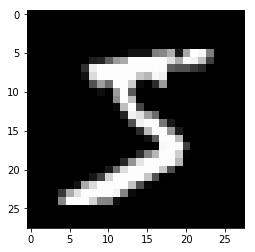

In [9]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [10]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [11]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [12]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

## PyTorch Class: torch.nn.modules.linear.

In [13]:
#def linear(input, weight, bias=None):
def my_linear(input, weight, bias=None):
    r"""
    Applies a linear transformation to the incoming data: :math:`y = xA^T + b`.

    Shape:

        - Input: :math:`(N, *, in\_features)` where `*` means any number of
          additional dimensions
        - Weight: :math:`(out\_features, in\_features)`
        - Bias: :math:`(out\_features)`
        - Output: :math:`(N, *, out\_features)`
    """
    
    """
    if input.dim() == 2 and bias is not None:
        # fused op is marginally faster
        #return torch.addmm(bias, input, weight.t())
        
        #my_weight = weight.detach().numpy()
        return np.matmul(input, weight.t(), bias )
    """
    
    output = input.matmul(weight.t())
    #my_weight = weight.detach().numpy()
    #output = np.matmul(input, weight.t())
    if bias is not None:
        output += bias
    return output


In [14]:
#class Linear(Module):
class my_Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, in\_features)` where :math:`*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where all but the last dimension
          are the same shape as the input.

    Attributes:
        weight: the learnable weights of the module of shape
            `(out_features x in_features)`
        bias:   the learnable bias of the module of shape `(out_features)`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
    """

    def __init__(self, in_features, out_features, bias=True):
        #super(Linear, self).__init__()
        super(my_Linear, self).__init__()
        #super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) 
        self.weight.data.uniform_(-stdv, stdv)    
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        #return F.linear(input, self.weight, self.bias)
        return my_linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [15]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = my_Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [16]:
model = Mnist_Logistic().cuda()

In [17]:
model

Mnist_Logistic(
  (lin): my_Linear(in_features=784, out_features=10, bias=True)
)

In [18]:
model.lin

my_Linear(in_features=784, out_features=10, bias=True)

In [19]:
model(x).shape

torch.Size([64, 10])

In [20]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [21]:
lr=2e-2

In [22]:
loss_func = nn.CrossEntropyLoss()

In [23]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [24]:
losses = [update(x,y,lr) for x,y in data.train_dl]

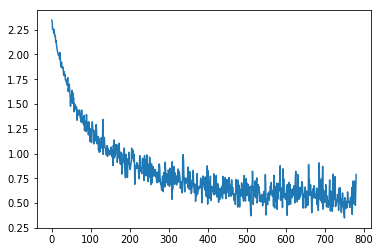

In [25]:
plt.plot(losses);

In [26]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [27]:
model = Mnist_NN().cuda()

In [28]:
losses = [update(x,y,lr) for x,y in data.train_dl]

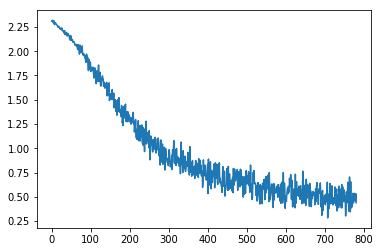

In [29]:
plt.plot(losses);

In [30]:
model = Mnist_NN().cuda()

In [31]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [32]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

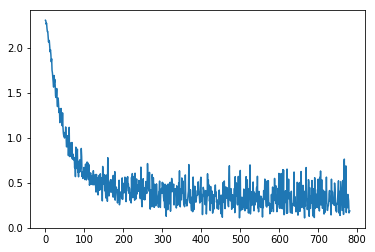

In [33]:
plt.plot(losses);

In [34]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


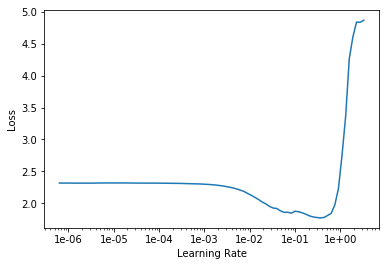

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.147097,0.132961,0.961600


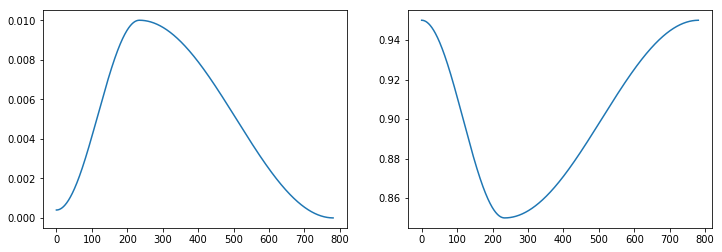

In [37]:
learn.recorder.plot_lr(show_moms=True)

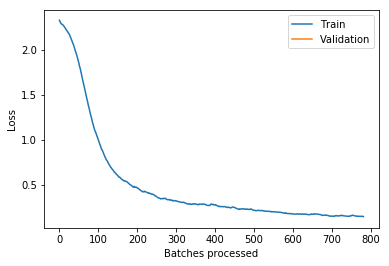

In [38]:
learn.recorder.plot_losses()

## fin